This is to a demo for the multi-output case. As we known, multi-label classification cannot predict the combination which is not seen in traning set. for example, 'black dress' not in traning set, so cannot be predicted during prediction. But multi-output classification can handle this well.
refer to https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)y

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/dataset/dataset"))
print(os.listdir("../input/examples/examples"))
train_set_dir = "../input/dataset/dataset"
test_set_dir = "../input/examples/examples"

# Any results you write to the current directory are saved as output.

['black_jeans', 'red_dress', 'blue_shirt', 'blue_dress', 'red_shirt', 'black_shoes', 'blue_jeans']
['red_shoes.jpg', 'black_jeans.jpg', 'red_shirt.jpg', 'black_dress.jpg', 'blue_shoes.jpg']


In [2]:
# import the necessary packages
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class FashionNet:
    @staticmethod
    def build_category_branch(inputs, numCategories,
        finalAct="softmax", chanDim=-1):
        # utilize a lambda layer to convert the 3 channel input to a
        # grayscale representation
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # define a branch of output layers for the number of different
        # clothing categories (i.e., shirts, jeans, dresses, etc.)
        x = Flatten()(x)
        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numCategories)(x)
        x = Activation(finalAct, name="category_output")(x)

        # return the category prediction sub-network
        return x

    @staticmethod
    def build_color_branch(inputs, numColors, finalAct="softmax",
        chanDim=-1):
        # CONV => RELU => POOL
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # define a branch of output layers for the number of different
        # colors (i.e., red, black, blue, etc.)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numColors)(x)
        x = Activation(finalAct, name="color_output")(x)

        # return the color prediction sub-network
        return x

    @staticmethod
    def build(width, height, numCategories, numColors,
        finalAct="softmax"):
        # initialize the input shape and channel dimension (this code
        # assumes you are using TensorFlow which utilizes channels
        # last ordering)
        inputShape = (height, width, 3)
        chanDim = -1

        # construct both the "category" and "color" sub-networks
        inputs = Input(shape=inputShape)
        categoryBranch = FashionNet.build_category_branch(inputs,
            numCategories, finalAct=finalAct, chanDim=chanDim)
        colorBranch = FashionNet.build_color_branch(inputs,
            numColors, finalAct=finalAct, chanDim=chanDim)

        # create the model using our input (the batch of images) and
        # two separate outputs -- one for the clothing category
        # branch and another for the color branch, respectively
        model = Model(
            inputs=inputs,
            outputs=[categoryBranch, colorBranch],
            name="fashionnet")

        # return the constructed network architecture
        return model

Using TensorFlow backend.


In [3]:
# USAGE
# python train.py --dataset dataset --model output/fashion.model \
#   --categorybin output/category_lb.pickle --colorbin output/color_lb.pickle

# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
#from pyimagesearch.fashionnet import FashionNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=True,
#    help="path to input dataset (i.e., directory of images)")
#ap.add_argument("-m", "--model", required=True,
#    help="path to output model")
#ap.add_argument("-l", "--categorybin", required=True,
#    help="path to output category label binarizer")
#ap.add_argument("-c", "--colorbin", required=True,
#    help="path to output color label binarizer")
#ap.add_argument("-p", "--plot", type=str, default="output",
#    help="base filename for generated plots")
#args = vars(ap.parse_args())

# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 10 # change from 50 to 10 for reducing time
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
#imagePaths = sorted(list(paths.list_images(args["dataset"])))
imagePaths = sorted(list(paths.list_images(train_set_dir)))
random.seed(42)
random.shuffle(imagePaths)

# initialize the data, clothing category labels (i.e., shirts, jeans,
# dresses, etc.) along with the color labels (i.e., red, blue, etc.)
data = []
categoryLabels = []
colorLabels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = img_to_array(image)
    data.append(image)

    # extract the clothing color and category from the path and
    # update the respective lists
    (color, cat) = imagePath.split(os.path.sep)[-2].split("_")
    categoryLabels.append(cat)
    colorLabels.append(color)

# scale the raw pixel intensities to the range [0, 1] and convert to
# a NumPy array
data = np.array(data, dtype="float") / 255.0
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
    len(imagePaths), data.nbytes / (1024 * 1000.0)))

# convert the label lists to NumPy arrays prior to binarization
categoryLabels = np.array(categoryLabels)
colorLabels = np.array(colorLabels)

# binarize both sets of labels
print("[INFO] binarizing labels...")
categoryLB = LabelBinarizer()
colorLB = LabelBinarizer()
categoryLabels = categoryLB.fit_transform(categoryLabels)
colorLabels = colorLB.fit_transform(colorLabels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, categoryLabels, colorLabels,
    test_size=0.2, random_state=42)
(trainX, testX, trainCategoryY, testCategoryY,
    trainColorY, testColorY) = split

# initialize our FashionNet multi-output network
model = FashionNet.build(96, 96,
    numCategories=len(categoryLB.classes_),
    numColors=len(colorLB.classes_),
    finalAct="softmax")

# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
    "category_output": "categorical_crossentropy",
    "color_output": "categorical_crossentropy",
}
lossWeights = {"category_output": 1.0, "color_output": 1.0}

# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
    metrics=["accuracy"])

# train the network to perform multi-output classification
H = model.fit(trainX,
    {"category_output": trainCategoryY, "color_output": trainColorY},
    validation_data=(testX,
        {"category_output": testCategoryY, "color_output": testColorY}),
    epochs=EPOCHS,
    verbose=1)

# save the model to disk
print("[INFO] serializing network...")
#model.save(args["model"])
model.save("fashion.model")

# save the category binarizer to disk
print("[INFO] serializing category label binarizer...")
#f = open(args["categorybin"], "wb")
f = open("category_lb.pickle", "wb")
f.write(pickle.dumps(categoryLB))
f.close()

# save the color binarizer to disk
print("[INFO] serializing color label binarizer...")
#f = open(args["colorbin"], "wb")
f = open("color_lb.pickle", "wb")
f.write(pickle.dumps(colorLB))
f.close()



[INFO] loading images...
[INFO] data matrix: 2521 images (544.54MB)
[INFO] binarizing labels...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[INFO] compiling model...
Instructions for updating:
Use tf.cast instead.
Train on 2016 samples, validate on 505 samples
Epoch 1/10
2016/2016 [==============================] - 159s 79ms/step - loss: 0.9245 - category_output_loss: 0.5703 - color_output_loss: 0.3542 - category_output_acc: 0.8239 - color_output_acc: 0.8725 - val_loss: 0.6431 - val_category_output_loss: 0.3102 - val_color_output_loss: 0.3329 - val_category_output_acc: 0.9050 - val_color_output_acc: 0.8693
Epoch 2/10
2016/2016 [==============================] - 155s 77ms/step - loss: 0.4017 - category_output_loss: 0.2933 - color_output_loss: 0.1084 - category_output_acc: 0.9008 - color_output_acc: 0.9608 - val_loss: 0.4294 - val_category_output_

Plot the accuary and loss for two outputs

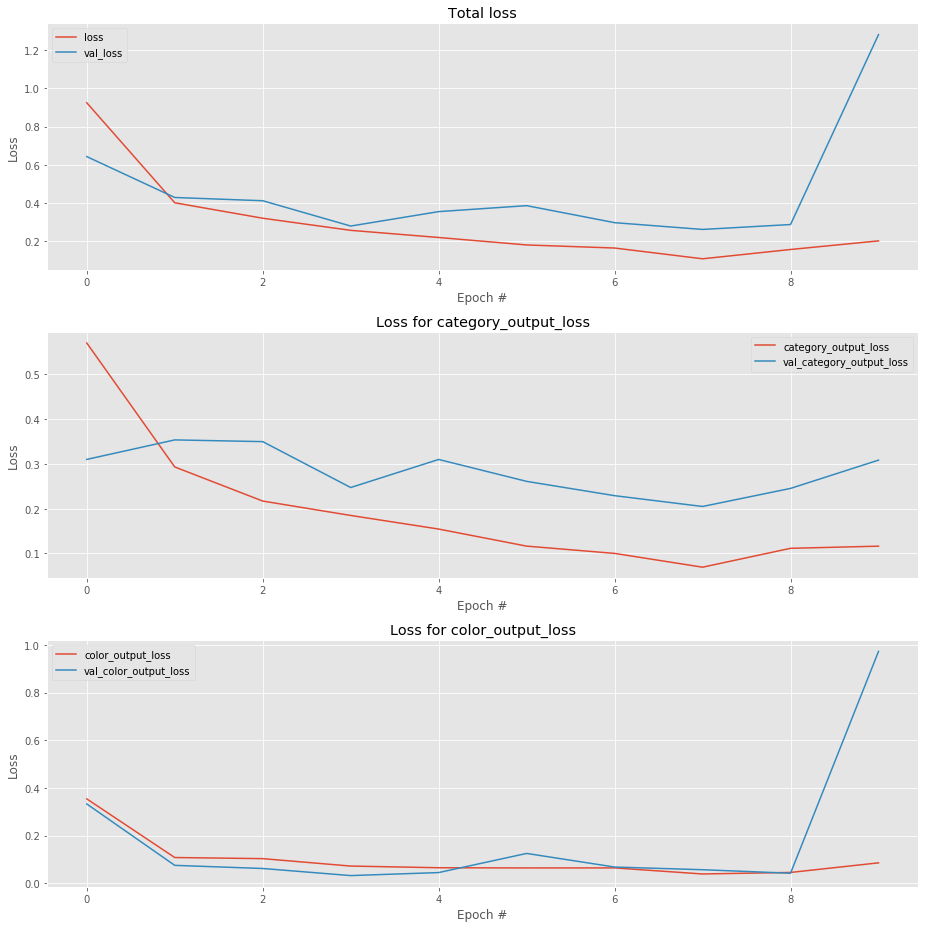

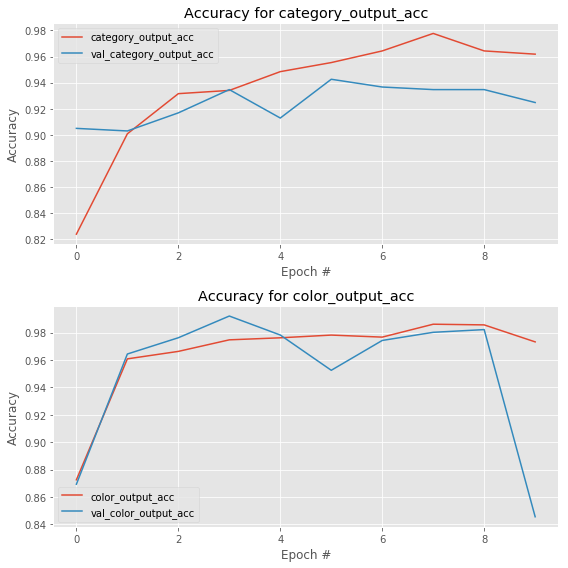

In [4]:
%matplotlib inline

# plot the total loss, category loss, and color loss
lossNames = ["loss", "category_output_loss", "color_output_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
        label="val_" + l)
    ax[i].legend()

# save the losses figure
plt.tight_layout()
#plt.savefig("{}_losses.png".format(args["plot"]))
plt.savefig("{}_losses.png".format("output"))
plt.show()
#plt.close()

# create a new figure for the accuracies
accuracyNames = ["category_output_acc", "color_output_acc"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(8, 8))

# loop over the accuracy names
for (i, l) in enumerate(accuracyNames):
    # plot the loss for both the training and validation data
    ax[i].set_title("Accuracy for {}".format(l))
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Accuracy")
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
        label="val_" + l)
    ax[i].legend()

# save the accuracies figure
plt.tight_layout()
#plt.savefig("{}_accs.png".format(args["plot"]))
plt.savefig("{}_accs.png".format("output"))
plt.show()
#plt.close()

(1, 96, 96, 3)
[INFO] loading network...
[INFO] classifying image...
1/1 [==============================] - 0s 475ms/step
[INFO] category: dress (91.76%)
[INFO] color: blue (69.95%)


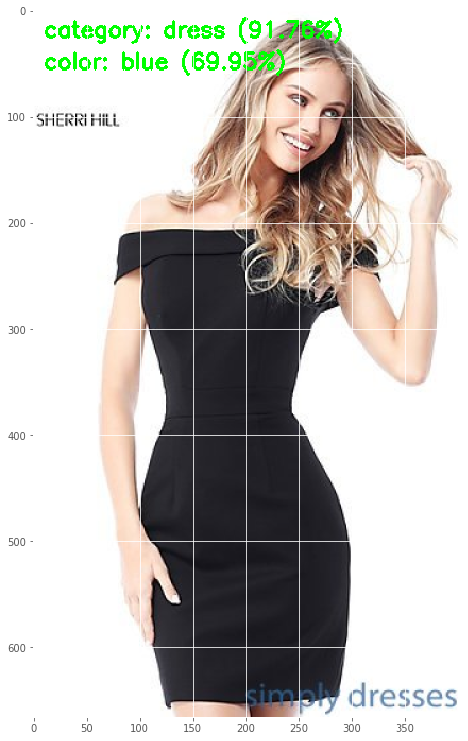

In [5]:
# USAGE
# python classify.py --model output/fashion.model \
#   --categorybin output/category_lb.pickle --colorbin output/color_lb.pickle \
#   --image examples/black_dress.jpg

# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import tensorflow as tf
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--model", required=True,
#    help="path to trained model model")
#ap.add_argument("-l", "--categorybin", required=True,
#    help="path to output category label binarizer")
#ap.add_argument("-c", "--colorbin", required=True,
#    help="path to output color label binarizer")
#ap.add_argument("-i", "--image", required=True,
#    help="path to input image")
#args = vars(ap.parse_args())

# load the image
#image = cv2.imread(args["image"])
image = cv2.imread(os.path.join(test_set_dir, 'black_dress.jpg'))

#cv2.imshow("img.jpg", image)
output = imutils.resize(image, width=400)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (96, 96))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
print (image.shape)

# load the trained convolutional neural network from disk, followed
# by the category and color label binarizers, respectively
print("[INFO] loading network...")
#model = load_model(args["model"], custom_objects={"tf": tf})
model = load_model("fashion.model", custom_objects={"tf": tf})
#categoryLB = pickle.loads(open(args["categorybin"], "rb").read())
#colorLB = pickle.loads(open(args["colorbin"], "rb").read())
categoryLB = pickle.loads(open("category_lb.pickle", "rb").read())
colorLB = pickle.loads(open("color_lb.pickle", "rb").read())

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
tmp = None
try:
    tmp = model.predict(image, steps=1, verbose=1)
except Exception as e:
    print (e.message)
(categoryProba, colorProba) = tmp

# find indexes of both the category and color outputs with the
# largest probabilities, then determine the corresponding class
# labels
categoryIdx = categoryProba[0].argmax()
colorIdx = colorProba[0].argmax()
categoryLabel = categoryLB.classes_[categoryIdx]
colorLabel = colorLB.classes_[colorIdx]

# draw the category label and color label on the image
categoryText = "category: {} ({:.2f}%)".format(categoryLabel,
    categoryProba[0][categoryIdx] * 100)
colorText = "color: {} ({:.2f}%)".format(colorLabel,
    colorProba[0][colorIdx] * 100)
cv2.putText(output, categoryText, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (0, 255, 0), 2)
cv2.putText(output, colorText, (10, 55), cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (0, 255, 0), 2)

# display the predictions to the terminal as well
print("[INFO] {}".format(categoryText))
print("[INFO] {}".format(colorText))

# show the output image
#cv2.imshow("Output", output)
#cv2.waitKey(0)
fig=plt.figure(figsize=(13,13))
img=cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()
